In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.spatial.distance

In [ ]:
IMAGE_PATH = "/content/drive/MyDrive/ImageTest/synthetic_image_1.png"
TEMPLATE_PATH = "/content/drive/MyDrive/ImageTest/white-Logo2-final.png"

In [ ]:
# WORKS
def load_images(image_path = IMAGE_PATH, template_path = TEMPLATE_PATH):
    img1 = cv2.imread(template_path)  # Template image (logo)
    img2 = cv2.imread(image_path)  # Query image

    if img1 is None or img2 is None:
        print("Error loading images!")
        return None, None
    return img1, img2

In [ ]:
template, image = load_images()

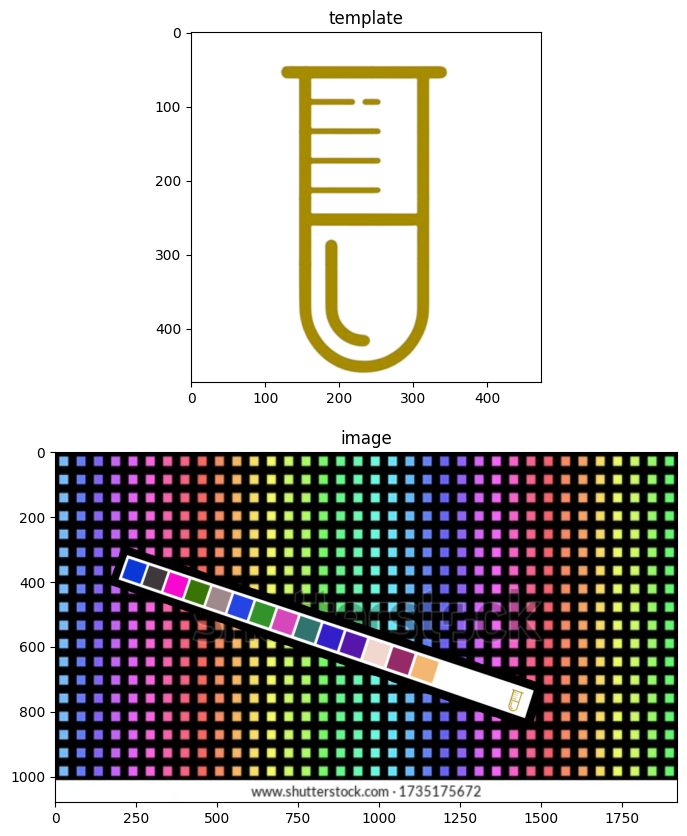

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(template)
plt.title("template")
plt.subplot(2,1,2)
plt.title("image")
plt.imshow(image)

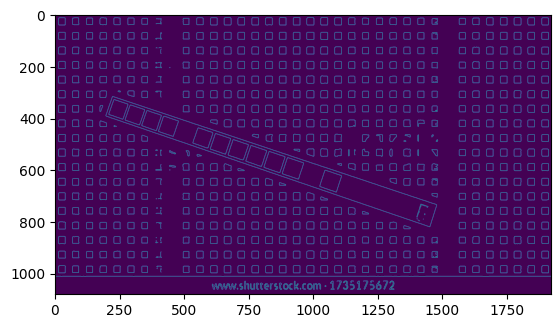

In [ ]:
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img_gray = cv2.medianBlur(img_gray, 3)
_, thresh = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY) # Should remove small lighting issues      # HYPERPARAMETER
edges = cv2.Canny(thresh, 100, 200, apertureSize=3) # HYPERPARAMETER
plt.imshow(edges)

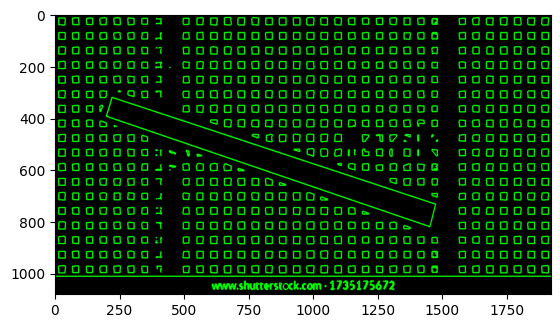

In [ ]:
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_copy = np.zeros_like(image)
if len(contours):
  for idx, contour in enumerate(contours):
    epsilon = 0.01 * cv2.arcLength(contour, True)
    contour = cv2.approxPolyDP(contour, epsilon, True)
    cv2.drawContours(image_copy, [contour], -1, (0, 255, 0), 3)
plt.imshow(image_copy)

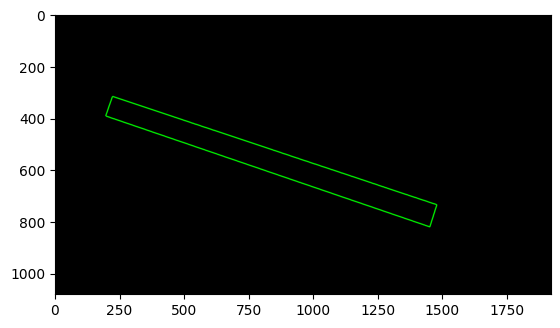

In [ ]:
min_contour_area = image.shape[0]*image.shape[1]*0.03 # HYPERPARAMETER (Later increase) # Should make computation easier later also remove the logo contour
max_contour_area = image.shape[0]*image.shape[1]*0.95  # HYPERPARAMETER (Later decrease)
filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_contour_area and cv2.contourArea(contour) < max_contour_area]
image_copy = np.zeros_like(image)
if len(filtered_contours):
  for idx, contour in enumerate(filtered_contours):
    cv2.drawContours(image_copy, [contour], -1, (0, 255, 0), 3)
plt.imshow(image_copy)

In [ ]:
orb = cv2.ORB_create()
image_gray_for_orb = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
template_gray_for_orb = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
kt, d_temp = orb.detectAndCompute(template_gray_for_orb, None)
ki, d_img = orb.detectAndCompute(image_gray_for_orb, None)
index_params = dict(algorithm=6,  # FLANN_INDEX_LSH
                    table_number=6,  # Number of hash tables
                    key_size=12,  # Size of the key for indexing
                    multi_probe_level=1)  # Number of probes for searching
search_params = dict(checks=5)  # Number of checks during search (higher value = more accuracy) # Hyperparameter (keep low to ensure that there is not much accuracy)
flann = cv2.FlannBasedMatcher(index_params, search_params)

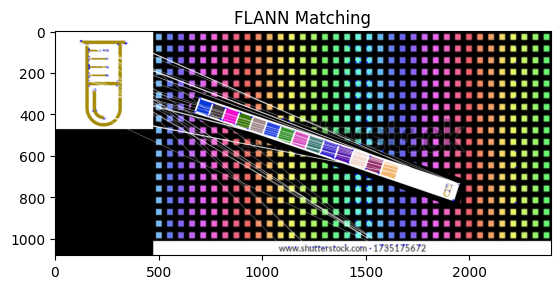

In [ ]:
matches = flann.knnMatch(d_temp, d_img, k=2)

good_matches = []
for m in matches:
    if len(m) == 2:  # Check if there are at least two matches
        # Apply Lowe's ratio test
        if m[0].distance < 0.8 * m[1].distance: # Hyperparameter
            good_matches.append(m[0])

# Draw matches on the images
img_matches = cv2.drawMatches(template, kt, image, ki, good_matches, None, matchColor=(255, 255, 255), singlePointColor=(0, 0, 255),flags=cv2.DrawMatchesFlags_DEFAULT)

# Show the result
plt.imshow(img_matches)
plt.title('FLANN Matching')
plt.show()

In [ ]:
good_points_template = []
good_points_image = []

# Extract matching points from the good matches
for match in good_matches:
    good_points_template.append(kt[match.queryIdx].pt)
    good_points_image.append(ki[match.trainIdx].pt)

# Convert the lists to numpy arrays for easier manipulation
good_points_template = np.array(good_points_template)
good_points_image = np.array(good_points_image)

In [ ]:
contour_matched = []

if len(filtered_contours) == 1:
  contour_matched.append(filtered_contours[0])
else:
  for contour in filtered_contours:
      match_count = 0
      for point in good_points_image:
          if cv2.pointPolygonTest(contour, tuple(point), False) >= 0:
              print("added")
              contour_matched.append(contour)
              break


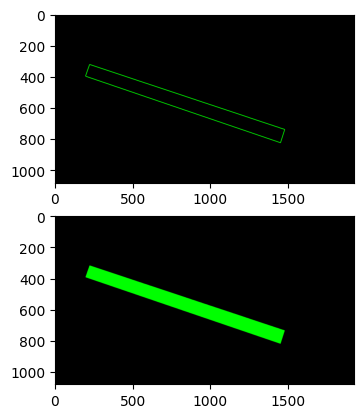

In [ ]:
image_copy_1 = np.zeros_like(image)
segmented_mask_intermediate = np.zeros_like(image)
if len(contour_matched):
  for idx, contour in enumerate(contour_matched):
    cv2.drawContours(image_copy_1, [contour], -1, (0, 255, 0), 3)
  largest_contour = max(contour_matched, key=cv2.contourArea)
  cv2.drawContours(segmented_mask_intermediate, [contour], -1, (0, 255, 0), -1)

plt.figure()
plt.subplot(2,1,1)
plt.imshow(image_copy_1)
plt.subplot(2,1,2)
plt.imshow(segmented_mask_intermediate)

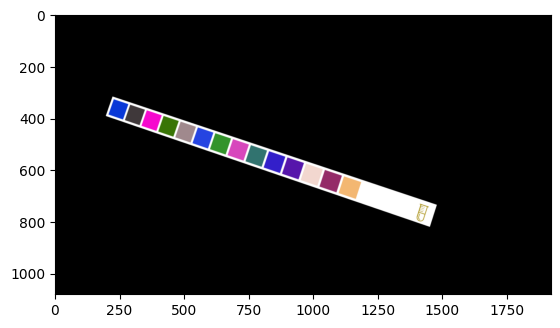

In [ ]:
if segmented_mask_intermediate.ndim == 3:
    final_mask = cv2.cvtColor(segmented_mask_intermediate, cv2.COLOR_BGR2GRAY)

_, final_mask = cv2.threshold(final_mask, 127, 255, cv2.THRESH_BINARY) # 127 Hyperparameter Decrease Later
segmented_strip_intermediate = cv2.bitwise_or(image,image,mask=final_mask)
plt.imshow(segmented_strip_intermediate)

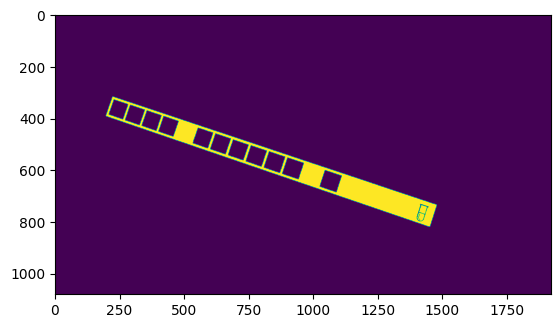

In [ ]:
segmented_strip_modified = cv2.cvtColor(segmented_strip_intermediate, cv2.COLOR_BGR2GRAY)
segmented_strip_modified = cv2.morphologyEx(segmented_strip_modified, cv2.MORPH_OPEN, None)
_, segmented_strip_modified = cv2.threshold(segmented_strip_modified, 127, 255, cv2.THRESH_BINARY)
plt.imshow(segmented_strip_modified)

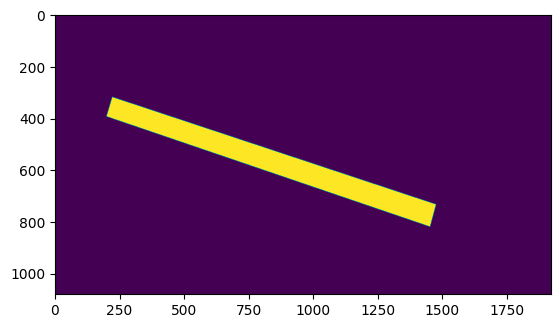

In [ ]:
contours_segmented, _ = cv2.findContours(segmented_strip_modified, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
segmented_strip_mask = np.zeros_like(image)
if len(contours_segmented):
  for idx, contour in enumerate(contours_segmented):
    epsilon = 0.01 * cv2.arcLength(contour, True)
    contour = cv2.approxPolyDP(contour, epsilon, True)
    cv2.drawContours(segmented_strip_mask, [contour], -1, (0, 255, 0), -1)
segmented_strip_mask = cv2.cvtColor(segmented_strip_mask, cv2.COLOR_BGR2GRAY)
_,segmented_strip_mask = cv2.threshold(segmented_strip_mask, 127, 255, cv2.THRESH_BINARY)
plt.imshow(segmented_strip_mask)

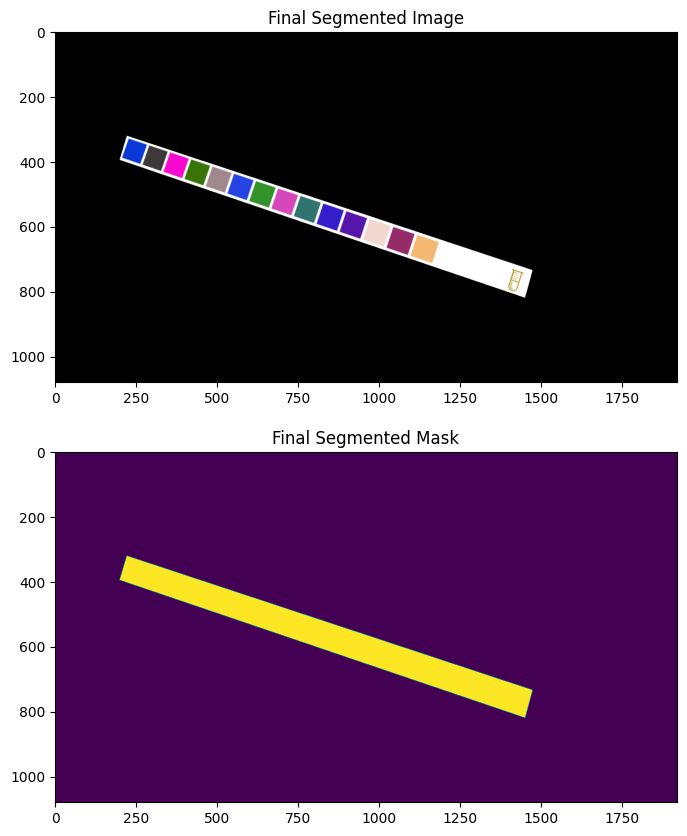

In [ ]:
segmented_strip = cv2.bitwise_or(image, image, mask=segmented_strip_mask)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title("Final Segmented Image")
plt.imshow(segmented_strip)
plt.subplot(2,1,2)
plt.title("Final Segmented Mask")
plt.imshow(segmented_strip_mask)
plt.show()

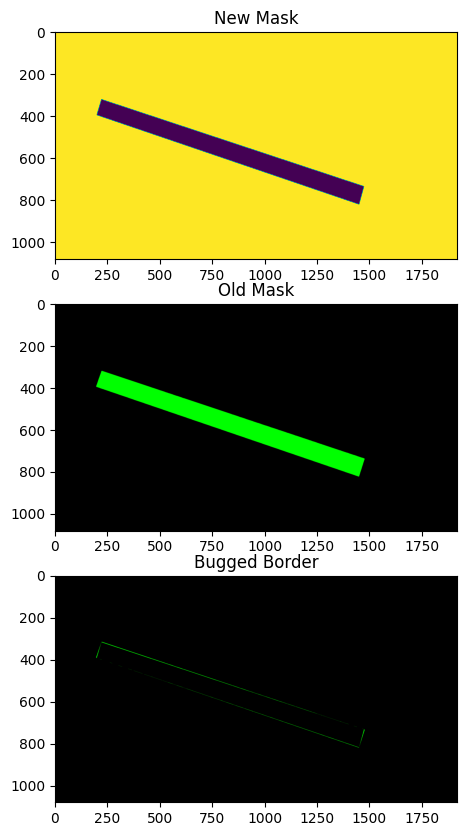

In [ ]:
segmented_strip_mask_not = cv2.bitwise_not(segmented_strip_mask)
border_bug_check = cv2.bitwise_and(segmented_mask_intermediate, segmented_mask_intermediate, mask=segmented_strip_mask_not)
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.title("New Mask")
plt.imshow(segmented_strip_mask_not)
plt.subplot(3,1,2)
plt.title("Old Mask")
plt.imshow(segmented_mask_intermediate)
plt.subplot(3,1,3)
plt.title("Bugged Border")
plt.imshow(border_bug_check)
plt.show()

In [ ]:
def order_pts(pts):

    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # Top-left has the smallest sum of coordinates
    rect[3] = pts[np.argmax(s)]  # Bottom-right has the largest sum of coordinates

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # Top-right has the smallest difference
    rect[2] = pts[np.argmax(diff)]  # Bottom-left has the largest difference

    return rect

Corner points: [[ 220.  322.]
 [ 201.  395.]
 [1449.  817.]
 [1469.  733.]]
Ordered points: [[ 220.  322.]
 [1469.  733.]
 [ 201.  395.]
 [1449.  817.]]


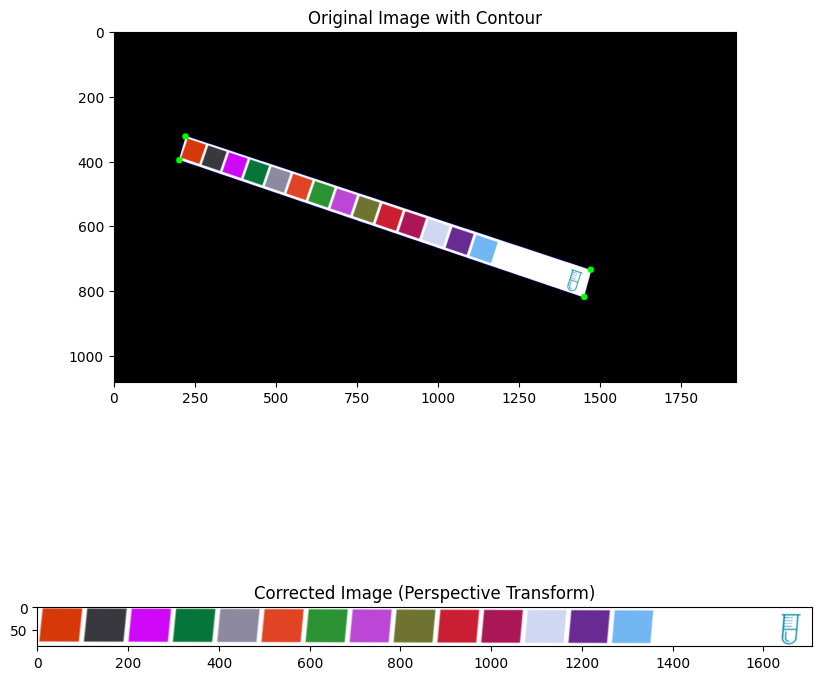

In [ ]:
# Copy the segmented strip image for contour marking
img = segmented_strip.copy()
img_with_contour = img.copy()
(rows, cols, _) = img.shape

# Image center
u0 = cols / 2.0
v0 = rows / 2.0

# Convert image to grayscale and find contours
contours, _ = cv2.findContours(cv2.cvtColor(segmented_strip, cv2.COLOR_BGR2GRAY), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if contours:
    # Get the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    cv2.drawContours(img_with_contour, [largest_contour], 0, (255, 0, 0), 1)

    # Approximate the contour to get the four corners
    epsilon = 0.01 * cv2.arcLength(largest_contour, True)
    approx_corners = cv2.approxPolyDP(largest_contour, epsilon, True)

    if len(approx_corners) == 4:
        # Extract the corner points from the contour approximation
        p = np.float32([point[0] for point in approx_corners])
        print("Corner points:", p)

        # Sort points to consistent ordering (Top-left, top-right, bottom-left, bottom-right)
        p = order_pts(p)
        print("Ordered points:", p)

        # Calculate distances to get width and height
        w1 = scipy.spatial.distance.euclidean(p[0], p[1])
        w2 = scipy.spatial.distance.euclidean(p[2], p[3])
        h1 = scipy.spatial.distance.euclidean(p[0], p[2])
        h2 = scipy.spatial.distance.euclidean(p[1], p[3])

        for (x, y) in p:
            cv2.circle(img_with_contour, (int(x), int(y)), 10, (0, 255, 0), -1)

        w = max(w1, w2)
        h = max(h1, h2)

        # Visible aspect ratio
        ar_vis = float(w) / float(h)

        # 3D homogeneous coordinates for each corner
        m1 = np.array((p[0][0], p[0][1], 1)).astype('float32')
        m2 = np.array((p[1][0], p[1][1], 1)).astype('float32')
        m3 = np.array((p[2][0], p[2][1], 1)).astype('float32')
        m4 = np.array((p[3][0], p[3][1], 1)).astype('float32')

        # Cross-ratio calculations
        k2 = np.dot(np.cross(m1, m4), m3) / np.dot(np.cross(m2, m4), m3)
        k3 = np.dot(np.cross(m1, m4), m2) / np.dot(np.cross(m3, m4), m2)

        n2 = k2 * m2 - m1
        n3 = k3 * m3 - m1

        # Camera focal length calculation
        f = np.sqrt(np.abs((1.0 / (n2[2] * n3[2])) *
                             ((n2[0] * n3[0] - (n2[0] * n3[2] + n2[2] * n3[0]) * u0 + n2[2] * n3[2] * u0 ** 2) +
                              (n2[1] * n3[1] - (n2[1] * n3[2] + n2[2] * n3[1]) * v0 + n2[2] * n3[2] * v0 ** 2))))

        # Intrinsic camera matrix
        A = np.array([[f, 0, u0], [0, f, v0], [0, 0, 1]]).astype('float32')

        # Real aspect ratio
        ar_real = np.sqrt(np.dot(np.dot(np.dot(n2, np.linalg.inv(A.T)), np.linalg.inv(A)), n2) /
                            np.dot(np.dot(np.dot(n3, np.linalg.inv(A.T)), np.linalg.inv(A)), n3))

        # Final dimensions based on real aspect ratio
        if ar_real < ar_vis:
            W = int(w)
            H = int(W / ar_real)
        else:
            H = int(h)
            W = int(ar_real * H)

        # Define points for perspective transform
        pts1 = np.array(p).astype('float32')
        pts2 = np.float32([[0, 0], [W, 0], [0, H], [W, H]])

        # Apply perspective transform
        M = cv2.getPerspectiveTransform(pts1, pts2)
        dst = cv2.warpPerspective(img, M, (W, H))

        # Display results
        plt.figure(figsize=(10, 10))
        plt.subplot(2, 1, 1)
        plt.title("Original Image with Contour")
        plt.imshow(cv2.cvtColor(img_with_contour, cv2.COLOR_BGR2RGB))
        plt.subplot(2, 1, 2)
        plt.title("Corrected Image (Perspective Transform)")
        plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        print("Could not find exactly 4 corners.")
else:
    print("No contours found.")


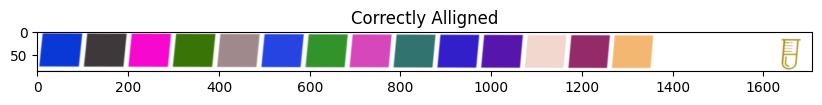

In [ ]:
if np.sum(dst[:,:int(0.1*dst.shape[1]),:])>np.sum(dst[:,int(0.9*dst.shape[1]):,:]):
  dst = cv2.rotate(dst, cv2.ROTATE_180)

plt.figure(figsize=(10, 10))
plt.imshow(dst, cmap='gray')
plt.title("Correctly Alligned")
plt.show()

(20, 1708, 3)
86 20
88 20
88 20
89 20
88 20
88 20
89 20
89 20
88 20
90 20
90 20
91 20
90 20


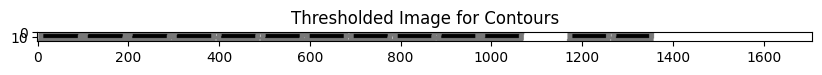

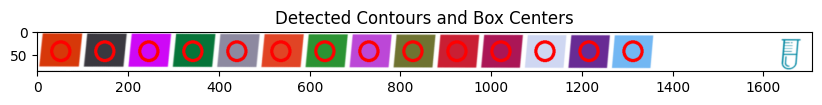

Calculated Box Centers: [52, 149, 246, 343, 440, 537, 634, 731, 828, 925, 1022, 1119, 1216, 1313]


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = dst.copy()

rows, cols, _ = img.shape

middle_row = np.ones((20,img.shape[1],img.shape[2]),dtype='uint8')*255
print(middle_row.shape)
middle_row[:, :int(0.9*cols), :] = img[rows//2-10:rows//2+10, :int(0.9*cols), :]
img

middle_row_gray = cv2.cvtColor(middle_row, cv2.COLOR_BGR2GRAY)

_, thresholded_row = cv2.threshold(middle_row_gray, 200, 255, cv2.THRESH_BINARY)



contours, _ = cv2.findContours(np.bitwise_not(thresholded_row), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

box_centers = []
for contour in contours:
    if cv2.contourArea(contour) > 100:  # Filter out small noise
        x, y, w, h = cv2.boundingRect(contour)
        print(w, h)
        box_center_x = x + w // 2
        box_centers.append(box_center_x)

box_centers.sort()

first_box = box_centers[0]
last_box = box_centers[-1]

total_width = last_box - first_box

distance_between_centers = total_width // 13  # There are 13 intervals between 14 boxes

calculated_centers = [first_box + i * distance_between_centers for i in range(14)]

cv2.drawContours(thresholded_row, contours, -1, (120), 10)  # Draw all contours in green

for center in calculated_centers:
    cv2.circle(img, (center, rows // 2), 20, (0, 0, 255), 5)  # Red circles at centers

plt.figure(figsize=(10, 10))
plt.imshow(thresholded_row, cmap='gray')
plt.title("Thresholded Image for Contours")
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Detected Contours and Box Centers")
plt.show()

print("Calculated Box Centers:", calculated_centers)


In [ ]:
def find_Color_center(img,y,x):
  return img[y,x]

img = (cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)).copy()
rows, cols, _ = img.shape

center_row = rows//2

for index, x in enumerate(calculated_centers):
  print(index+1, find_Color_center(img,center_row,x))

1 [215  56   9]
2 [58 56 63]
3 [206   8 246]
4 [  6 117  57]
5 [141 137 160]
6 [225  68  37]
7 [ 43 147  51]
8 [188  71 215]
9 [111 115  49]
10 [202  31  51]
11 [171  22  86]
12 [207 215 242]
13 [104  43 148]
14 [114 183 243]


In [ ]:
def find_Color_center_one(img,y,x, percentage):
  '''removes noise by taking mean''' # TODO: Before this add lighting compensation somewhat to make it work
  box_half_side = int(percentage*img.shape[1])//2

  y_start = y-box_half_side
  y_end = y+box_half_side
  x_start = x-box_half_side
  x_end = x+box_half_side

  return np.mean(img[y_start: y_end, x_start: x_end].reshape(-1,3), axis=0)

img = (cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)).copy()
rows, cols, _ = img.shape

center_row = rows//2

for index, x in enumerate(calculated_centers):
  print(index+1, find_Color_center_one(img,center_row,x, 0.02))


1 [215.  56.   9.]
2 [58. 56. 63.]
3 [206.   8. 246.]
4 [  6. 117.  57.]
5 [141. 137. 160.]
6 [225.  68.  37.]
7 [ 43. 147.  51.]
8 [188.  71. 215.]
9 [111. 115.  49.]
10 [202.  31.  51.]
11 [171.  22.  86.]
12 [207. 215. 242.]
13 [104.  43. 148.]
14 [114. 183. 243.]
